In [8]:
import re
import string


def clean_text(text):
    # Remove unicode characters
    text = re.sub('[^\x00-\x7F]+', '', text)
    # Convert to python ASCII string
    text = str(text.encode('ascii'))
    # Convert to lowercase
    text = text.lower()
    # Remove new line characters
    text = text.replace('\n',' ')
    # Remove links
    text = re.sub('http\S+', '', text)
    # Remove punctuation 
    to_remove = string.punctuation.replace("'",'')
    text = re.sub('['+to_remove+']+', '', text)
    # Remove numbers
    text = re.sub('\d', '', text)
    return text
        

def clean_dictionary(dictionary):
    for _, value in dictionary.items():
        value['title'] = clean_text(value['title'])
        comments = value['comments']
        for i in range(len(comments)):
             comments[i] = clean_text(comments[i])
        value['comments'] = comments
    return dictionary

def pos_tag(doc):
    pos = []
    for d in doc:
        pos.append(nltk.pos_tag(d))
    return pos


def eliminate_pos(pos, chosen):
    keep_list = []
    for d in pos:
        keep = [word[0] for word in d if word[1] in chosen]
        keep_list.append(keep)
    return keep_list

In [ ]:
# Only include nouns, adjectives
chosen = ['NN','NNS','NNP','NNPS']
 
top_doc_short = eliminate_pos(pos_tag(top_doc), chosen)
contro_doc_short = eliminate_pos(pos_tag(contro_doc), chosen)

# Retrieve data from MongoDB

In [57]:
import pymongo
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client.reddit_database
collection_top = db.reddit_top
collection_contro = db.reddit_contro

In [58]:
collection_top.count()

1030

In [59]:
# Create list of comments from 'controversial' submissions
def create_docs(collection, how):
    docs = []
    for d in collection.find():
        if how == 'sep':
            docs.append(clean_text(d['title']))
            comments_only = [clean_text(x[0]) for x in d['comments']]
            docs.extend(comments_only)
        else:
            title = clean_text(d['title'])
            comments = ' '
            for c in d['comments']:
                comments = comments + ' ' + clean_text(c[0])
            docs.append(title + comments)
    return docs

In [92]:
contro_tfidf = create_docs(collection_contro, how ='together')
top_tfidf = create_docs(collection_top, how ='together')

### Get rid of posts in both document lists

In [93]:
# RUN TWICE
count = 0
for c in contro_tfidf:
    for t in top_tfidf:
        if c == t:
            count += 1
            top_tfidf.remove(t)
print count

40


# LDA with Count / TFIDF Vectorizer

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1),
#                                    stop_words='english',
#                                    token_pattern='\\b[a-z][a-z]+\\b',
#                                    max_df=0.05, min_df=2)
# dtm_count = count_vectorizer.fit_transform((top_tfidf + contro_tfidf)).transpose()

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),
                                   lowercase = True,
                                   stop_words='english',
                                   token_pattern='\\b[a-z][a-z]+\\b',
                                   max_df=0.3, min_df=2)
dtm_tfidf = tfidf_vectorizer.fit_transform((top_tfidf + contro_tfidf)).transpose()

In [132]:
dtm_tfidf.shape   # Num doc x num features / terms

(22847, 2017)

In [133]:
import gensim
from gensim import models

corpus = gensim.matutils.Sparse2Corpus(dtm_tfidf)

In [134]:
# id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.iteritems())
id2word = {}
for i,val in enumerate(tfidf_vectorizer.get_feature_names()):
    id2word[i] = val
#print id2word

In [142]:
lda = models.LdaModel(corpus, id2word=id2word, num_topics=30, passes=1)

In [143]:
lda.print_topics(num_words=4, num_topics=30)

[(0, u'0.035*party + 0.013*speak + 0.010*concern + 0.010*eh'),
 (1, u'0.032*polish + 0.009*coitus + 0.009*tutorial + 0.008*tasks'),
 (2, u'0.000*job + 0.000*question + 0.000*going + 0.000*cat'),
 (3, u'0.020*wake + 0.014*boyfriend + 0.014*separate + 0.012*sleep'),
 (4, u'0.034*gag + 0.029*watermark + 0.021*gym + 0.016*gagcom'),
 (5, u'0.013*grandparents + 0.012*comedies + 0.012*quilts + 0.012*wedding'),
 (6, u'0.048*cheating + 0.016*sausage + 0.013*cheap + 0.012*role'),
 (7, u'0.018*earlier + 0.015*tv + 0.011*retarded + 0.006*anal'),
 (8, u'0.016*maneuver + 0.013*reposted + 0.011*bob + 0.010*sucks'),
 (9, u'0.010*sanitation + 0.000*water + 0.000*man + 0.000*dog'),
 (10, u'0.010*workforce + 0.001*looks + 0.000*work + 0.000*morning'),
 (11, u'0.028*london + 0.021*generally + 0.008*tang + 0.003*cupcake'),
 (12, u'0.024*intercept + 0.021*aircraft + 0.020*british + 0.017*chinese'),
 (13, u'0.028*pigeon + 0.010*condoms + 0.007*flock + 0.007*trafalgar'),
 (14, u'0.027*photograph + 0.011*gentl

In [144]:
lda_corpus = lda[corpus]

In [145]:
lda_docs = [doc for doc in lda_corpus]

In [146]:
def assign_topic_id2word(lda_docs):
    topics = []
    for prob_list in lda_docs:
        sort = sorted(prob_list, key=lambda x: x[1], reverse=True)
        topics.append(sort[0][0])
    return topics

Total variance:  -2.082e-17


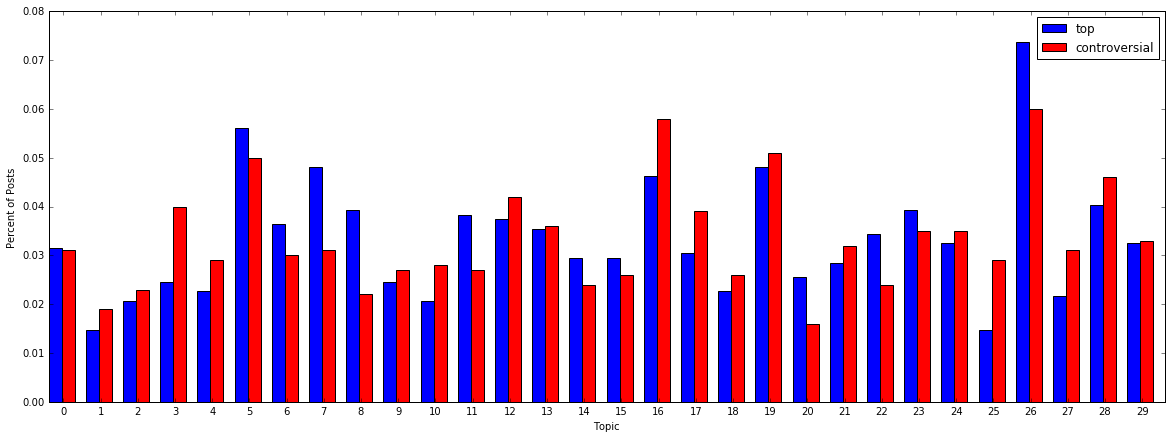

In [147]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
%matplotlib inline

topics_top = assign_topic_id2word(lda_docs[:len(top_tfidf)])
topics_contro = assign_topic_id2word(lda_docs[len(top_tfidf):])

topic_count_top2 = Counter(topics_top)
topic_count_contro2 = Counter(topics_contro)

y_top2 = [(topic_count_top2[topic] / float(len(topics_top))) for topic in topic_count_top2.keys()]
y_contro2 = [(topic_count_contro2[topic] / float(len(topics_contro))) for topic in topic_count_contro2.keys()]
xs = np.arange(0,len(y_top2))

plt.figure(figsize=(20,7))
plt.bar(xs, y_top2, 0.35, label = 'top', color='b')
plt.bar(xs + 0.35, y_contro2, 0.35, label = 'controversial', color='r')
plt.xlabel('Topic')
plt.ylabel('Percent of Posts')
plt.xticks(xs + 0.4,xs)
plt.legend()
plt.xlim(0,len(y_top2))

print 'Total variance: ', round(sum(np.array(y_top2) - np.array(y_contro2)),20)

# NMF

In [157]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),
                                   lowercase = True,
                                   stop_words='english',
                                   token_pattern='\\b[a-z][a-z]+\\b',
                                   max_df=0.3, min_df=2)
dtm_tfidf = tfidf_vectorizer.fit_transform((top_tfidf + contro_tfidf))

In [158]:
model = NMF(n_components = 20)
nmf = model.fit(dtm_tfidf)

In [159]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_top_words(nmf, tfidf_vectorizer.get_feature_names(), 5)

Topic #0:
money pay work make job
Topic #1:
direct link direct link link exist link image
Topic #2:
looks looks like look nice picture
Topic #3:
game games play played pc
Topic #4:
movie film trailer movies ghostbusters
Topic #5:
feedback bot original reduced tldr make best tldr
Topic #6:
cat cats cute kitty ocelot
Topic #7:
dog dogs puppy cute pup
Topic #8:
baby horny cute poor baby new baby
Topic #9:
press channel hydraulic press hydraulic press channel
Topic #10:
song album music love rock
Topic #11:
comments tag parent removed posts
Topic #12:
cake happy day cakes eat
Topic #13:
eat food chicken vegan vegans
Topic #14:
climate climate change moon change earth
Topic #15:
women men gay sex male
Topic #16:
cancer hiv johnson aids magic johnson
Topic #17:
books book read reading series
Topic #18:
car drive cars driving waited
Topic #19:
day did life got said
